# Performance

Perfomance (also die Geschwindigkeit der Ausführung) ist bei realen (wissenschaftlichen) Problemen schnell ein wichtiger Aspekt um das gegebene Problem gut und schnell zu lösen.

**Einflussfaktoren**

- Algorithmus
- *Implementation*
- Betriebssytem und Programmiersprache
- Hardware


*Avoid premature optimization*

### Beispiel: Mandelbrot

Die Mandelbrot-Menge ist die Menge von Punkten $c \in \mathbb{C}$ bei denen die Folge $(z_n)_n$, die durch
$$ z_0:=c, \qquad z_{n+1} = z_n^2 +c, \quad n \in \mathbb{N}$$
definiert ist, beschränkt ist.

Die zu schreibende Funktion gibt zu jedem $c=x+iy$ die Anzahl der Iterationsschritte zurück bis die Folge divergiert und das bilden wir dann auf eine Farbe mittels imshow().  

mandelbox (simpleloop)  31.681 s


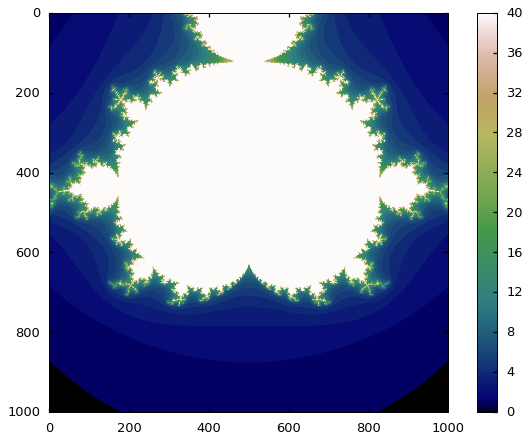

In [1]:
from numpy import ogrid, zeros, copy
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from time import time

def mandelbox_simpleloop (C):
    Z = copy(C)

    it_max = 40
    Anz = zeros(Z.shape)

    for i in range(0,Z.shape[0]):
        for j in range(0,Z.shape[0]):
            for k in range(1,it_max+1):
                Z[i,j] = Z[i,j]**2 + C[i,j]
                if abs(Z[i,j])<2.5: 
                    Anz[i,j] += 1
                else:
                    break

    return Anz,X,Y

# koordinaten
xsize = 2.0
ysize = 2.0
cent = [0., 0.]
si = 1000
[X,Y] = ogrid[cent[0]-xsize/2.:cent[0]+xsize/2.:si*1j,cent[1]-ysize/2.:cent[1]+ysize/2.:si*1j]
C = (X + 1j*Y)


tic = time()
Anz,X,Y = mandelbox_simpleloop (C)
print("mandelbox (simpleloop) {:7.3f} s".format(time()-tic))


plt.imshow(Anz, cmap='gist_earth')
plt.colorbar()
plt.show()

Soweit so gut. Schauen wir uns doch mal an *was* oder vielmehr *wo* das Programm langsam ist.

## Profiler
Tool um Performance-Engstellen (*bottlenecks*) und Fehler (Bugs) herauszufinden.

###  cProfile

* Anzahl Funktionsaufrufe
* Zeit pro Funktionsaufruf und gesamt durch die jeweilige Funktion

``` python
python -m cProfile -o <output.txt>  <script.py>
```

In [1]:
%%bash
python -m cProfile -o mandelprofile.txt ../mandel.py

mandelbox (simpleloop)   8.262 s


Dann können wir uns die Datei direkt oder mit dem Modul `pstats` ansehen.

``` python
pstats.Stats(filename)
```

- sort_stats('spalte'): sortiert nach der entsprechenden Spalte
- print_stats(anzzeilen): gibt die ersten anzzeilen Zeilen aus.

In [1]:
import pstats
p = pstats.Stats('mandelprofile.txt')
p.strip_dirs().sort_stats('time').print_stats(20)

Mon Sep 12 19:25:45 2016    mandelprofile.txt

         5188866 function calls (5167171 primitive calls) in 9.947 seconds

   Ordered by: internal time
   List reduced from 4521 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    7.858    7.858    8.262    8.262 mandel.py:13(mandelbox_simpleloop)
      213    0.606    0.003    0.606    0.003 {built-in method builtins.compile}
  4527624    0.402    0.000    0.402    0.000 {built-in method builtins.abs}
       14    0.073    0.005    0.073    0.005 {method 'get_filename' of 'zipimport.zipimporter' objects}
     14/1    0.071    0.005    0.268    0.268 {method 'load_module' of 'zipimport.zipimporter' objects}
      517    0.057    0.000    0.057    0.000 {built-in method marshal.loads}
2116/1942    0.045    0.000    0.302    0.000 {built-in method builtins.__build_class__}
    55/54    0.032    0.001    0.042    0.001 {built-in method _imp.create_dynamic}
  969/242    0.020  

Alternativ in spyder:
- *F10*: Startet das gegebene Programm im grafischen Profiler.
- Der Profiler listet alle Funktionen in ihrer Hierarchie auf und zeigt deren Zeitverbrauch.


Das ganze hilft uns leider noch relativ wenig.. wir wissen ja schon, dass mandelbox_simpleloop die ganze Arbeit macht, aber wo?

### line profiler
Der *line_profiler*  kann exakt sagen, welche Zeilen wieviel Zeit verbraucht haben. 

Dafür benutzt man den ```@profile``` decorator:

``` python
@profile
def function ():
    ...
```

und ruft dann (ausserhalb von spyder) den eigentlichen Profiler auf:

``` bash
kernprof.py -l -v <file.py>
``` 


In [1]:
%%bash
kernprof.py -l -v ../mandel.py

mandelbox (simpleloop)  35.701 s
Wrote profile results to mandel.py.lprof
Timer unit: 1e-06 s

File: ../mandel.py
Function: mandelbox_simpleloop at line 13
Total time: 25.2878 s

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           @profile
    14                                           def mandelbox_simpleloop (C):
    15         1         1942   1942.0      0.0      Z = copy(C)
    16                                           
    17         1            1      1.0      0.0      it_max = 40
    18         1           11     11.0      0.0      Anz = zeros(Z.shape)
    19                                           
    20       501          333      0.7      0.0      for i in range(0,Z.shape[0]):
    21    250500       136687      0.5      0.5          for j in range(0,Z.shape[0]):
    22   4618900      2538266      0.5     10.0              for k in range(1,it_max+1):
    23   4527028     10633830      2.3     42.1           

Hieraus lernen wir jetzt, dass die Zeilen in der Schleife die meiste Zeit brauchen. Was könnten wir besser machen?

1. Es sind lauter Indizierungen vorhanden die unnötig sind. Wir können temporäre Variablen erzeugen in der Schleife

In [1]:
def mandelbox_betterloop (C):
    it_max = 40
    Anz = zeros(C.shape)

    for i in range(0,C.shape[0]):
        for j in range(0,C.shape[0]):
            cij = C[i,j]
            zij = cij
            count = 0
            for k in range(1,it_max+1):
                zij = zij**2 + cij
                if abs(zij)<2.5: 
                    count += 1
                else:
                    break                    
            Anz[i,j] = count
    return Anz

tic = time()
Anz = mandelbox_betterloop (C)
print("mandelbox (betterloop) {:7.3f} s".format(time()-tic))

mandelbox (betterloop)  11.207 s


In [1]:
%%bash
kernprof.py -l -v ../mandelbetter.py

mandelbox (simpleloop)  37.276 s
Wrote profile results to mandelbetter.py.lprof
Timer unit: 1e-06 s

File: ../mandelbetter.py
Function: mandelbox_betterloop at line 13
Total time: 25.683 s

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           @profile
    14                                           def mandelbox_betterloop (C):
    15         1            2      2.0      0.0      it_max = 40
    16         1           30     30.0      0.0      Anz = zeros(C.shape)
    17                                           
    18       501          318      0.6      0.0      for i in range(0,C.shape[0]):
    19    250500       140166      0.6      0.5          for j in range(0,C.shape[0]):
    20    250000       207419      0.8      0.8              cij = C[i,j] 
    21    250000       133687      0.5      0.5              zij = cij
    22    250000       128595      0.5      0.5              count = 0
    23   4913374      2688982     

../mandelbetter.py:24: RuntimeWarning: overflow encountered in cdouble_scalars
  zij = zij**2 + cij
../mandelbetter.py:24: RuntimeWarning: invalid value encountered in cdouble_scalars
  zij = zij**2 + cij


Das ist deutlich besser auch zu sehen an den Zeilen wo indiziert wird.

Wie kriegt man es nun noch schneller? Eine weitere Möglichkeit sind...

## NumPy - tricks

NumPy/SciPy ist durchaus gut optimiert und schnell. Man sollte jedoch Schleifen über Arrays vermeiden und stattdessen *slices* benutzen. Das ist nicht nur schneller sondern auch kürzer und manchmal auch besser lesbar (und man braucht keine Indizes). Aus dem Gleichen Grund ist allgemein das Nutzen von Array-Operationen besser.

*Warum for-loops langsam sind*:
Hier muss Python jedesmal unter anderen die Typen prüfen, was einen grossen Overhead bedeutet. Wenn man NumPy mit slices aufruft wird intern direkt auf den Speicher zugegriffen.

Also:

**Array-Operationen und Slicing > Loops und Indexing**

*Beispiel:* 1D-Distanz

In [1]:
from numpy.random import randn
from numpy import zeros

a = randn(1000000)
d = zeros(a.shape[0]-1)

In [1]:
%%timeit
for i in range(0,len(d)):
    d[i] = a[i]-a[i+1]

1 loop, best of 3: 449 ms per loop


In [1]:
%%timeit
d[:] = a[:-1]-a[1:]

1000 loops, best of 3: 1.85 ms per loop


Das macht auch unsere Mandelbrot-Funktion deutlich besser: Wir nutzen einfach Arrays als ganzes

In [1]:
def mandelbox (C):
    Z = copy(C)

    it_max = 40
    Anz = zeros(Z.shape)

    for k in range(1,it_max+1):
        Z = Z**2+C
        Anz += abs(Z)<2.5
    return Anz

tic = time()
Anz = mandelbox (C)
print("mandelbox (arrays) {:7.3f} s".format(time()-tic))

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in square
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in square
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in absolute
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less


mandelbox (arrays)   0.858 s


Allerdings machen wir hier auch einiges unnötig zuviel: In jedem Punkt werden bis `it_max` alle Folgen-elemente ausgerechnet. Vielleicht können wir sowohl den Nachteil der Loops umgehen als auch nicht unnötig Operationen durchführen?
Dafür ein Blick auf wie Python mit Code umgeht..

## Just In Time compiler - numba

Python *interpretiert* den Code zur Laufzeit und muss dabei dynamisch die Typen erkennen, die benötigt werden. Das erzeugt signifikanten Overhead (siehe auch oben bzgl. *slices*). 

**J**ust **I**n **T**ime (JIT) compiler erkennen beim erstmaligen Aufruf möglichst die Typen und kompilieren dann den Code mit statischen Typen, so dass die Typ-Checks nicht mehr nötig sind. Das kann eine erhebliche Verschnellerung bewirken. 

Das Modul was uns das hier leistet heisst
``` python
import numba
```

Die praktische Nutzung ist erstmal einfach: Wir dekorieren die Funktion die kompiliert werden soll mit dem decorator

```python
@numba.jit()
```

*Hinweis:* Der unterliegende Mechanismus ist nicht trivial und es gibt diverse Stellen wo das schief gehen kann. Für eine besser Kontrolle müßte man mehr von Typen verstehen. 

*Faustregel*: wende @jit auf Funktionen an ..

- die möglichst Basis-Typen enthalten
- die (viele) Schleifen enthalten

In [1]:
from numba import jit

@jit
def mandelbox (C):
    Z = copy(C)

    it_max = 40
    Anz = zeros(Z.shape)

    for k in range(1,it_max+1):
        Z = Z**2+C
        Anz += abs(Z)<2.5
    return Anz


tic = time()
Anz = mandelbox (C)
print("mandelbox (arrays+jit) {:7.3f} s".format(time()-tic))

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in square
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in square
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in absolute
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less


mandelbox (arrays+jit)   1.069 s


Das ist sogar erstmal langsamer! Das liegt am Overhead des Kompilierens
-> Wir müssen ein größeres Problem betrachten: Z.B. $si=2000$

Wenden wir @jit auf unsere "better" loop an, das sollte viel bringen

In [1]:
@jit
def mandelbox_betterloop (C):
    it_max = 40
    Anz = zeros(C.shape)
    for i in range(0,C.shape[0]):
        for j in range(0,C.shape[0]):
            cij = C[i,j]
            zij = cij
            count = 0
            for k in range(1,it_max+1):
                zij = zij**2 + cij
                if abs(zij) < 2.5: 
                    count += 1
                else:
                    break                    
            Anz[i,j] = count
    return Anz


tic = time()
Anz = mandelbox_betterloop (C)
print("mandelbox (betterloop+jit) {:7.3f} s".format(time()-tic))

mandelbox (betterloop+jit)   0.283 s


Das ist schneller als die Numpy-Lösung! Das liegt daran, dass diese zuviel berechnet (alle Iterationen für jeden Punkt).

Wir wollen das noch etwas *schöner* schreiben indem wir funktionale Sichtweise benutzen und eine weitere Funktion erstellen, die gegeben ein Punkt die Mandelbrot-Folge berechnet.

In [1]:
@jit
def mandelone(C):
    Anz = zeros(C.shape)
  
    for a in range(0,C.shape[0]):
        for b in range(0,C.shape[0]):
            Anz[a,b] = mandel(C[a,b])
    return Anz

@jit
def mandel(c):
    z = c
    maxiter = 40
    for n in range(0,maxiter):
        if abs(z) > 2.5:
            return n-1
        z = z**2 + c
    return maxiter

tic = time()
Anz = mandelone(C)
print("mandelone {:7.3f} s".format(time()-tic))

mandelone   0.285 s
